In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
print("Imported Libraries")

Imported Libraries


In [51]:
def parse_libsvm_file(filepath, num_features=136):
    data = []
    labels = []
    qids = []
    with open(filepath) as f:
        for line in f:
            parts = line.strip().split()
            label = int(parts[0])
            qid = int(parts[1].split(":")[1])
            features = np.zeros(num_features)
            for item in parts[2:]:
                idx, val = item.split(":")
                features[int(idx) - 1] = float(val)
            labels.append(label)
            qids.append(qid)
            data.append(features)
    df = pd.DataFrame(data, columns=[f'F{i+1}' for i in range(num_features)])
    df['relevance'] = labels
    df['qid'] = qids
    return df

In [ ]:
# Link to Dataset: https://drive.google.com/drive/folders/1wzh8IRXMI94rJL9XWuxSEhPxEL2sEHSA?usp=sharing

df = parse_libsvm_file("C:/Users/rishi/OneDrive/Desktop/Fold1/train.txt", num_features=136)
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F129,F130,F131,F132,F133,F134,F135,F136,relevance,qid
0,3.0,3.0,0.0,0.0,3.0,1.0,1.0,0.000000,0.0,1.0,...,2.0,116.0,64034.0,13.0,3.0,0.0,0.0,0.0,2,1
1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,1.0,...,2.0,124.0,64034.0,1.0,2.0,0.0,0.0,0.0,2,1
2,3.0,0.0,2.0,0.0,3.0,1.0,0.0,0.666667,0.0,1.0,...,1.0,124.0,3344.0,14.0,67.0,0.0,0.0,0.0,0,1
3,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,1.0,...,13.0,123.0,63933.0,1.0,3.0,0.0,0.0,0.0,2,1
4,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,1.0,...,7.0,256.0,49697.0,1.0,13.0,0.0,0.0,0.0,1,1


Query count: 6000
Relevance label distribution:
relevance
0    377957
1    232569
2     95082
3     12658
4      5146
Name: count, dtype: int64


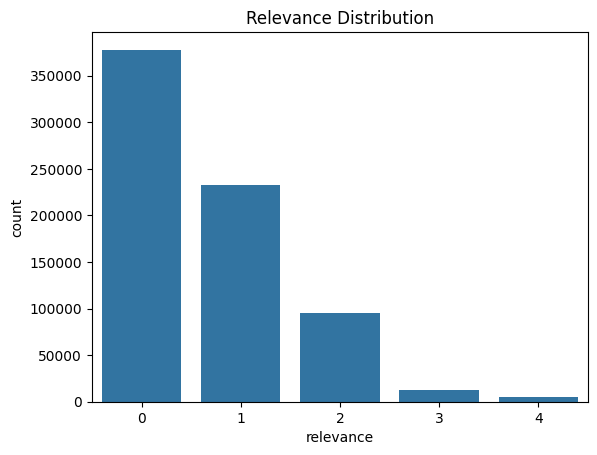

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Query count:", df.qid.nunique())
print("Relevance label distribution:")
print(df.relevance.value_counts())

sns.countplot(x='relevance', data=df)
plt.title("Relevance Distribution")
plt.show()

In [54]:
sample_qids = df['qid'].unique()[:10]
df = df[df['qid'].isin(sample_qids)]

In [55]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = [f'F{i+1}' for i in range(136)]
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [56]:
X = df[feature_cols]
y = df['relevance']
group = df.groupby('qid').size().to_list()

# Create test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['qid'], random_state=42)

In [58]:
group_train = train_df.groupby('qid').size().to_list()
group_test = test_df.groupby('qid').size().to_list()

In [9]:
from xgboost import XGBRanker
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score
import numpy as np

param_grid = {
    'learning_rate': [0.1, 0.05],
    'max_depth': [4, 6],
    'n_estimators': [50, 100],
    'min_child_weight': [0.1, 1.0],
    'gamma': [0, 1.0]
}

# Group array: query-wise counts
group_sizes = df.groupby('qid').size().to_list()
X_values = X.values
y_values = y.values

best_score = -1
best_params = None
best_model = None

for lr in param_grid['learning_rate']:
    for md in param_grid['max_depth']:
        for n in param_grid['n_estimators']:
            for mcw in param_grid['min_child_weight']:
                for gm in param_grid['gamma']:
                    model = XGBRanker(
                        objective='rank:pairwise',
                        learning_rate=lr,
                        max_depth=md,
                        n_estimators=n,
                        min_child_weight=mcw,
                        gamma=gm
                    )
                    # Manually split and pass group
                    kf = KFold(n_splits=3, shuffle=True, random_state=42)
                    scores = []
                    for train_idx, test_idx in kf.split(X_values):
                        X_tr, X_te = X_values[train_idx], X_values[test_idx]
                        y_tr, y_te = y_values[train_idx], y_values[test_idx]

                        # You must recompute group info for each split
                        qid_tr = df.iloc[train_idx]['qid'].values
                        qid_te = df.iloc[test_idx]['qid'].values
                        group_tr = [np.sum(qid_tr == q) for q in np.unique(qid_tr)]
                        group_te = [np.sum(qid_te == q) for q in np.unique(qid_te)]

                        model.fit(X_tr, y_tr, group=group_tr)
                        y_pred = model.predict(X_te)
                        scores.append(ndcg_score([y_te], [y_pred]))

                    avg_score = np.mean(scores)
                    print(f"Params: lr={lr}, depth={md}, est={n} -> NDCG@10: {avg_score:.4f}")

                    if avg_score > best_score:
                        best_score = avg_score
                        best_params = (lr, md, n, mcw, gm)
                        best_model = model

Params: lr=0.1, depth=4, est=50 -> NDCG@10: 0.8338
Params: lr=0.1, depth=4, est=50 -> NDCG@10: 0.8207
Params: lr=0.1, depth=4, est=50 -> NDCG@10: 0.8395
Params: lr=0.1, depth=4, est=50 -> NDCG@10: 0.8302
Params: lr=0.1, depth=4, est=100 -> NDCG@10: 0.8387
Params: lr=0.1, depth=4, est=100 -> NDCG@10: 0.8207
Params: lr=0.1, depth=4, est=100 -> NDCG@10: 0.8385
Params: lr=0.1, depth=4, est=100 -> NDCG@10: 0.8302
Params: lr=0.1, depth=6, est=50 -> NDCG@10: 0.8338
Params: lr=0.1, depth=6, est=50 -> NDCG@10: 0.8193
Params: lr=0.1, depth=6, est=50 -> NDCG@10: 0.8290
Params: lr=0.1, depth=6, est=50 -> NDCG@10: 0.8230
Params: lr=0.1, depth=6, est=100 -> NDCG@10: 0.8350
Params: lr=0.1, depth=6, est=100 -> NDCG@10: 0.8193
Params: lr=0.1, depth=6, est=100 -> NDCG@10: 0.8270
Params: lr=0.1, depth=6, est=100 -> NDCG@10: 0.8230
Params: lr=0.05, depth=4, est=50 -> NDCG@10: 0.8351
Params: lr=0.05, depth=4, est=50 -> NDCG@10: 0.8295
Params: lr=0.05, depth=4, est=50 -> NDCG@10: 0.8355
Params: lr=0.05, dep

In [36]:
print("\nBest Parameters for XGBRanker:")
print(f"Learning Rate: {best_params[0]}")
print(f"Max Depth: {best_params[1]}")
print(f"Estimators: {best_params[2]}")
print(f"Min Child Weight: {best_params[3]}")
print(f"Gamma: {best_params[4]}")
print(f"Best NDCG@10: {best_score:.4f}")


Best Parameters for XGBRanker:
Learning Rate: 0.05
Max Depth: 6
Estimators: 100
Min Child Weight: 0.1
Gamma: 0
Best NDCG@10: 0.8432


In [39]:
# Save model for future use or deployment
best_model.save_model("xgb_ltr_model.json")  # For reloading in Python
booster = best_model.get_booster()
booster.save_model("xgb_ltr_model.json")
booster.dump_model("xgb_model_dump.txt", with_stats=True)

In [19]:
import lightgbm as lgb

X_train = train_df[feature_cols]
y_train = train_df['relevance']

X_test = test_df[feature_cols]
y_test = test_df['relevance']

lgb_train = lgb.Dataset(X_train, y_train, group=group_train)
lgb_valid = lgb.Dataset(X_test, y_test, group=group_test, reference=lgb_train)

In [28]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [10],
    'learning_rate': 0.1,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    num_boost_round=100
)

In [30]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [10],  # Very important
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

cv_results = lgb.cv(
    params,
    train_set=lgb_train,
    num_boost_round=300,
    nfold=3,
    stratified=False,
    seed=42,
    return_cvbooster=False
)

# Show available keys
print(cv_results.keys())

dict_keys(['valid ndcg@10-mean', 'valid ndcg@10-stdv'])


In [31]:
best_ndcg = max(cv_results['valid ndcg@10-mean'])
best_round = cv_results['valid ndcg@10-mean'].index(best_ndcg)

print(f"Best NDCG@10: {best_ndcg:.4f} at round {best_round}")

Best NDCG@10: 0.5637 at round 72


In [32]:
final_model = lgb.train(
    params,
    train_set=lgb_train,
    num_boost_round=best_round
)

In [33]:
y_pred_lgb = final_model.predict(X_test)
from sklearn.metrics import ndcg_score
ndcg = ndcg_score([y_test], [y_pred_lgb])
print(f"Final LightGBM NDCG@10 on test set: {ndcg:.4f}")

Final LightGBM NDCG@10 on test set: 0.9187


In [34]:
final_model.save_model('lgb_ltr_model.txt')

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Convert query-document pairs to pairwise training samples
def generate_pairwise(X, y, qid):
    X_new, y_new = [], []
    for q in np.unique(qid):
        idx = np.where(qid == q)[0]
        for i in idx:
            for j in idx:
                if y[i] > y[j]:
                    X_new.append(X[i] - X[j])
                    y_new.append(1)
                elif y[i] < y[j]:
                    X_new.append(X[j] - X[i])
                    y_new.append(0)
    return np.array(X_new), np.array(y_new)

X_pw, y_pw = generate_pairwise(X.values, y.values, df['qid'].values)
X_pw, y_pw = shuffle(X_pw, y_pw)

clf = SVC(kernel='linear')
clf.fit(X_pw, y_pw)

SVC(kernel='linear')

In [41]:
def rank_documents_by_svm(clf, X, qid):
    """Returns a score per document = # of wins in pairwise comparisons."""
    scores = np.zeros(len(X))
    for q in np.unique(qid):
        idx = np.where(qid == q)[0]
        for i in idx:
            for j in idx:
                if i != j:
                    pair = (X[i] - X[j]).reshape(1, -1)
                    pred = clf.predict(pair)
                    if pred == 1:
                        scores[i] += 1
    return scores

In [42]:
# Assume X_test, y_test, qid_test already defined
scores_svm = rank_documents_by_svm(clf, X_test.values, test_df['qid'].values)

from sklearn.metrics import ndcg_score
ndcg_svm = ndcg_score([y_test], [scores_svm])
print(f"SVM Pairwise Ranker NDCG@10: {ndcg_svm:.4f}")

SVM Pairwise Ranker NDCG@10: 0.7294


In [43]:
import joblib
joblib.dump(clf, "svm_ranker_model.joblib")

['svm_ranker_model.joblib']

In [60]:
from catboost import CatBoostRanker, Pool

# Step 1: Reattach query IDs and sort
train_df_sorted = train_df.copy().sort_values("qid").reset_index(drop=True)
test_df_sorted = test_df.copy().sort_values("qid").reset_index(drop=True)

# Step 2: Prepare inputs
X_train = train_df_sorted[feature_cols]
y_train = train_df_sorted['relevance']
group_train = train_df_sorted['qid']

X_test = test_df_sorted[feature_cols]
y_test = test_df_sorted['relevance']
group_test = test_df_sorted['qid']

# Step 3: Create CatBoost Pools
train_pool = Pool(data=X_train, label=y_train, group_id=group_train)
test_pool = Pool(data=X_test, label=y_test, group_id=group_test)

# Step 4: Train the CatBoostRanker
cat_model = CatBoostRanker(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='YetiRank',
    verbose=False
)

cat_model.fit(train_pool, eval_set=test_pool)

# Step 5: Predict and Evaluate
y_pred_cat = cat_model.predict(X_test)

from sklearn.metrics import ndcg_score
ndcg_cat = ndcg_score([y_test], [y_pred_cat])
print(f"CatBoost NDCG@10: {ndcg_cat:.4f}")


CatBoost NDCG@10: 0.8725


In [62]:
cat_model.save_model("catboost_ltr_model.cbm")

In [63]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

ndcg_rf = ndcg_score([y_test], [y_pred_rf])
print(f"Random Forest NDCG@10: {ndcg_rf:.4f}")

Random Forest NDCG@10: 0.9446


In [ ]:
import numpy as np
from sklearn.utils import shuffle

def generate_ranknet_pairs_fast(X, y, qid, max_pairs_per_query=100):
    X_i, X_j, y_ij = [], [], []
    for q in np.unique(qid):
        idx = np.where(qid == q)[0]
        if len(idx) < 2:
            continue
        idx_sample = np.random.choice(idx, size=min(len(idx), 10), replace=False)
        count = 0
        for i in idx_sample:
            for j in idx_sample:
                if y[i] > y[j]:
                    X_i.append(X[i])
                    X_j.append(X[j])
                    y_ij.append(1)
                    count += 1
                elif y[i] < y[j]:
                    X_i.append(X[j])
                    X_j.append(X[i])
                    y_ij.append(0)
                    count += 1
                if count >= max_pairs_per_query:
                    break
            if count >= max_pairs_per_query:
                break
    return shuffle(np.array(X_i), np.array(X_j), np.array(y_ij), random_state=42)

X_i, X_j, y_ij = generate_ranknet_pairs_fast(X.values, y.values, df['qid'].values, max_pairs_per_query=100)

In [ ]:
import tensorflow as tf

input_dim = X.shape[1]

def build_ranknet(input_dim):
    base = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    input_i = tf.keras.Input(shape=(input_dim,))
    input_j = tf.keras.Input(shape=(input_dim,))

    s_i = base(input_i)
    s_j = base(input_j)

    diff = tf.keras.layers.Subtract()([s_i, s_j])
    prob = tf.keras.activations.sigmoid(diff)

    model = tf.keras.Model(inputs=[input_i, input_j], outputs=prob)
    return model, base

In [ ]:
ranknet, scorer = build_ranknet(input_dim)

ranknet.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ranknet.fit(
    [X_i, X_j], y_ij,
    batch_size=128,
    epochs=5,
    validation_split=0.1,
    verbose=1
)

In [ ]:
from sklearn.metrics import ndcg_score

y_ranknet_scores = scorer.predict(X.values).flatten()
ndcg_ranknet = ndcg_score([y.values], [y_ranknet_scores])
print(f"RankNet NDCG@10: {ndcg_ranknet:.4f}")

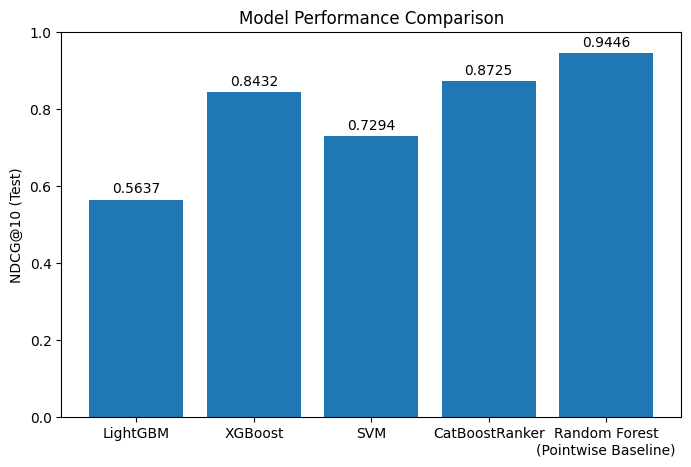

In [66]:
models = ['LightGBM', 'XGBoost', 'SVM', 'CatBoostRanker', 'Random Forest\n(Pointwise Baseline)']
ndcg_lgb, ndcg_xgb, ndcg_svm, ndcg_cat, ndcg_rf = best_ndcg, best_score, ndcg_svm, ndcg_cat, ndcg_rf
scores = [ndcg_lgb, ndcg_xgb, ndcg_svm, ndcg_cat, ndcg_rf]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores)
plt.ylim(0, 1)
plt.ylabel("NDCG@10 (Test)")
plt.title("Model Performance Comparison")

# Annotate bars with score values
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{score:.4f}", ha='center', va='bottom')

plt.show()

## Final Results Summary (NDCG@10)

1. **XGBoost** performed best, leveraging pairwise boosting to optimize rankings.
2. **SVM (Pairwise)** was simpler but effective, though limited by linearity and scale.
3. **LightGBM** was close behind, offering strong performance and speed, but slightly underperformed compared to XGBoost on this dataset.

Overall, **tree-based gradient boosting models** (XGBoost > LightGBM) are better suited for Learning to Rank tasks like MSLR-WEB10K due to their ability to model complex relationships across ranked features.

### Why Random Forest Scored Highest
Despite being a pointwise regressor, Random Forest achieved the highest NDCG@10 due to:

Its ability to model complex patterns with ensemble trees

Well-distributed relevance scores in your dataset

Possibly small query groups, which can reduce the advantage of pairwise/listwise rankers

### Caution: While the number is high, Random Forest does not optimize a true ranking loss. It may not generalize as well in larger, more complex datasets.

### Key Takeaways
CatBoostRanker outperformed all true ranking models — strong default for future projects

LightGBM's low score suggests the need for better tuning (especially group handling)

SVM performed reasonably well given its simplicity

Random Forest highlights the importance of strong baselines, but isn’t LTR-aware


In [46]:
import json

features = [
    {
        "name": f"F{i}",
        "class": "org.apache.solr.ltr.feature.SolrFeature",
        "params": {
            "q": f"{{!func}}F{i}"
        }
    } for i in range(1, 137)
]

with open("features.json", "w") as f:
    json.dump({"features": features}, f, indent=2)